In [1]:
import os
import numpy as np
import pandas as pd
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample as sobol_sample
from SALib.analyze.sobol import analyze as sobol_analyze
import matplotlib.pyplot as plt
from autoemulate.compare import AutoEmulate
from SALib.analyze.sobol import analyze
import numpy as np
import json
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
# Load them back
n_samples = 32768
simulation_out_path = f'outputs/simulations/output_{n_samples}_samples'

with open(os.path.join(simulation_out_path,"bool_indices.json"), 'r') as f:
    bool_indices = json.load(f)

- load input_256_samples.csv
- load simulation_summary.csv 

Get rid of those rows in input_256_camples that correspond to bool_indices

In [3]:
# Load input_32768_samples.csv
input_csv = os.path.join(simulation_out_path, "input_samples_32768.csv")
X = pd.read_csv(input_csv)
print("Loaded input samples:", X.shape)

# Load simulation_summary.csv
summary_csv = os.path.join(simulation_out_path, "simulations_summary.csv")
Y = pd.read_csv(summary_csv)
print("Loaded simulation summary:", Y.shape)

Loaded input samples: (32768, 35)
Loaded simulation summary: (32640, 32)


In [4]:
# Lets get cleaning and removing 

# Take only the columns up to column 'T' 
t_column_index = X.columns.get_loc('T')
X = X.iloc[:, :t_column_index + 1]

# Remove rows at the indices in bool_indices
X_cleaned = X.drop(index=bool_indices).reset_index(drop=True)
print("Cleaned input samples:", X_cleaned.shape)  # Should be (255, 35)

Cleaned input samples: (32640, 17)


In [5]:
# Generate random 128 indices between 0-255
random_indices = np.random.choice(X_cleaned.index, size=32300, replace=False)

# Select the rows at these indices
X_random = X_cleaned.loc[random_indices].reset_index(drop=True)

# do the same for Y
Y_random = Y.loc[random_indices].reset_index(drop=True)

In [6]:
parameter_names = list(X.columns)
parameter_bounds = []
for name in parameter_names:
    min_val = X_random[name].min()
    max_val = X_random[name].max()
    parameter_bounds.append([min_val, max_val])

problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}
print(problem)



{'num_vars': 17, 'names': ['ao.r', 'ao.c', 'art.r', 'art.c', 'ven.r', 'ven.c', 'av.r', 'mv.r', 'la.E_pas', 'la.E_act', 'la.v_ref', 'la.k_pas', 'lv.E_pas', 'lv.E_act', 'lv.v_ref', 'lv.k_pas', 'T'], 'bounds': [[120.00524058938026, 359.9944634735584], [0.1500069740228355, 0.4499917041510343], [562.5144451623783, 1687.4726142268628], [1.5000866493210196, 4.499947934411466], [4.50023656245321, 13.499879443086684], [66.65072873290629, 199.9493532029912], [3.0001065395772457, 8.999865526333451], [2.0500211846083403, 6.149927610345184], [0.2200043145939707, 0.6599989927560092], [0.2250065500382334, 0.6749931042082609], [5.0000642985105515, 14.999918416142464], [0.016651209124457, 0.0749990483511239], [0.5000182408839464, 1.49997890740633], [1.5000264812260866, 4.4999516839161515], [5.000140406191349, 14.999732924625278], [0.0099901227927021, 0.0449992030212376], [300.02036299556494, 1199.9853366985917]]}


In [7]:
import numpy as np

output_feature = "v_la_mean"  # Change to any column name in Y

Y_feature = Y_random[output_feature].values  # .values converts to numpy array.

# Run Sobol sensitivity analysis (first-order only)
sobol_indices = sobol_analyze(problem, Y_feature, calc_second_order=False)

# Sorting using argsort function S1 indices returns in ascending order, so we reverse it with [::-1], so biggest first
names = np.array(problem['names'])  # Names should match columns of X_cleaned
S1 = np.array(sobol_indices['S1'])
S1_conf = np.array(sobol_indices['S1_conf'])  # Uncertainties of the S1 indices
sorted_idx = np.argsort(S1)[::-1]
S1_sorted = S1[sorted_idx]
S1_conf_sorted = S1_conf[sorted_idx]
names_sorted = names[sorted_idx]

# Show the sorted sensitivities
for n, s, c in zip(names_sorted, S1_sorted, S1_conf_sorted):
    print(f"{n}: S1={s:.3f} ± {c:.3f}")

T: S1=0.047 ± 0.067
ven.r: S1=0.027 ± 0.074
av.r: S1=0.026 ± 0.069
la.v_ref: S1=0.023 ± 0.077
ven.c: S1=0.014 ± 0.075
la.k_pas: S1=0.010 ± 0.067
lv.v_ref: S1=0.004 ± 0.066
art.r: S1=0.001 ± 0.071
la.E_act: S1=0.000 ± 0.069
la.E_pas: S1=-0.006 ± 0.076
art.c: S1=-0.010 ± 0.065
ao.c: S1=-0.012 ± 0.072
ao.r: S1=-0.013 ± 0.071
lv.k_pas: S1=-0.016 ± 0.074
lv.E_pas: S1=-0.017 ± 0.068
mv.r: S1=-0.017 ± 0.060
lv.E_act: S1=-0.038 ± 0.073


/Users/syonis/project/comparative-gsa/venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


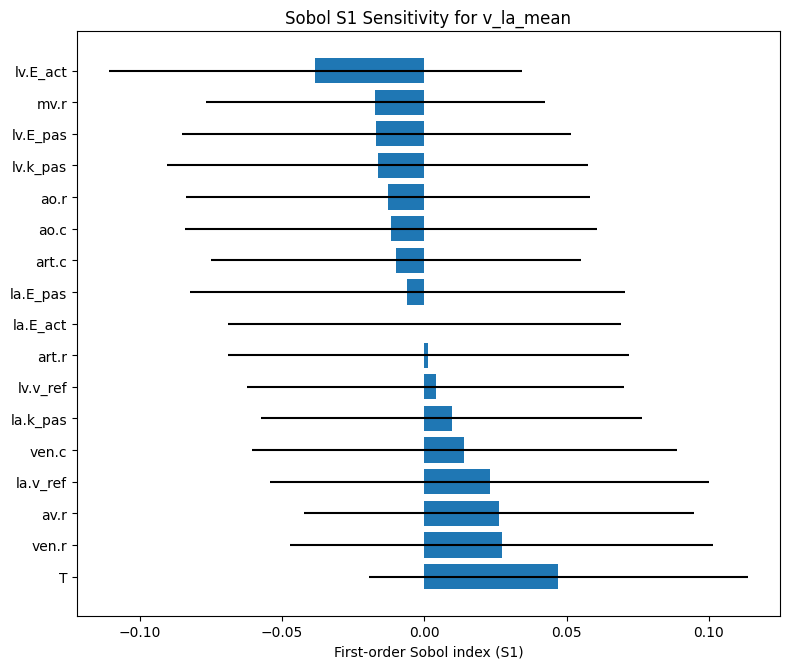

In [8]:
import matplotlib.pyplot as plt

# Plotting the sortd s1 indicies as a horizontal bar chart for now will explore heatmaps and piecharts later
y = np.arange(len(names_sorted))
plt.figure(figsize=(8, max(4, 0.4 * len(names_sorted))))
plt.barh(y, S1_sorted, xerr=S1_conf_sorted, color='#1f77b4')
plt.yticks(y, names_sorted)
plt.xlabel("First-order Sobol index (S1)")
plt.title(f"Sobol S1 Sensitivity for {output_feature}")
plt.tight_layout()
plt.show()